In [61]:
import os
import numpy as np
import pandas as pd
import re
import string
import torch
from torch import nn
from time import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split

### Constants:

In [33]:
# constants
class config:
    FILE = './data.txt'
    SOS_token = 0
    EOS_token = 1
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    EPOCHS = 20
    CLIP = 1
    MAX_LENGTH = 128
    BATCH_SIZE = 32
    LEARNING_RATE = 0.05

In [34]:
#!wget -qO- https://github.com/Z5-05/nlp_made_2023/raw/main/labs/lab_2/archives/dataset.tar.gz | tar xvz

if not os.path.exists(config.FILE):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc

In [35]:
%%time
df = pd.read_csv(
    "data.txt", sep="\t", lineterminator="\n", header=None, names=['en', 'ru']
)

CPU times: user 202 ms, sys: 7.99 ms, total: 210 ms
Wall time: 211 ms


In [36]:
def normalize(x: str):
    exclude = set(string.punctuation)
    digit = str.maketrans("", "", string.digits)

    x = re.sub("'", "", str(x).lower())
    x = "".join(ch for ch in x if ch not in exclude)
    x = x.translate(digit)
    return x

In [37]:
df["en"] = df["en"].apply(normalize)
df["ru"] = df["ru"].apply(normalize)

In [38]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_en, train_ru, valid_en, valid_ru = (
    train_df["en"].values,
    train_df["ru"].values,
    valid_df["en"].values,
    valid_df["ru"].values,
)
train_size = train_df.shape[0]
valid_size = valid_df.shape[0]

train_batch_nums, valid_batch_nums = (
    train_size // config.BATCH_SIZE,
    valid_size // config.BATCH_SIZE,
)

In [39]:
del df
del train_df
del valid_df

In [40]:
# using pretrained model and then finetunig it on our dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-ru")

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [41]:
for param in model.parameters():
        param.requires_grad = False
    
in_features = model.lm_head.in_features
out_features = model.lm_head.out_features
hidden_features = 256

model.lm_head = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_features, out_features))
#model.lm_head = nn.Linear(in_features, out_features)
model = model.to(config.DEVICE)

In [42]:
optimizer = torch.optim.AdamW(model.lm_head.parameters(), lr=config.LEARNING_RATE)

In [43]:
def remove_tech_tokens(list_of_str, tokens_to_remove=["<s>", "</s>", "<unk>", "<pad>"]):
    return [
        [x.replace("</s>", "") for x in my_str.split(" ") if x not in tokens_to_remove]
        for my_str in list_of_str
    ]

In [44]:
def model_train(model):
    
    train_losses = []
    valid_losses = []
    
    train_times = []
    valid_times = []

    for epoch in range(config.EPOCHS):
        train_loss = 0
        model.train()
        for i in range(train_batch_nums):
            start_time = time()
            src, trg = (
                train_en[
                    i * config.BATCH_SIZE : (i + 1) * config.BATCH_SIZE,
                ],
                train_ru[
                    i * config.BATCH_SIZE : (i + 1) * config.BATCH_SIZE,
                ],
            )
            batch = tokenizer.prepare_seq2seq_batch( 
                list(src), list(trg), return_tensors="pt"
            ).to(config.DEVICE)
            output = model(**batch)
            loss = output.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss = train_loss + loss.item()
            end_time = time()
            train_times.append(end_time - start_time)
            
        train_losses.append(train_loss / train_batch_nums)

        valid_loss = 0
        model.eval()
        for i in range(valid_batch_nums):
            start_time = time()
            src, trg = (
                valid_en[
                    i * config.BATCH_SIZE : (i + 1) * config.BATCH_SIZE,
                ],
                valid_ru[
                    i * config.BATCH_SIZE : (i + 1) * config.BATCH_SIZE,
                ],
            )
            batch = tokenizer.prepare_seq2seq_batch(
                list(src), list(trg), return_tensors="pt"
            ).to(config.DEVICE)
            output = model(**batch)
            
            loss = output.loss
            valid_loss = valid_loss + loss.item()
            end_time = time()
            valid_times.append(end_time - start_time)
        
        valid_losses.append(valid_loss / valid_batch_nums)
        print(
            "Train loss: {}, valid loss: {}".format(
                train_loss / train_batch_nums, valid_loss / valid_batch_nums
            )
        )

    return model, train_losses, valid_losses, train_times, valid_times

In [45]:
model, train_losses, valid_losses, train_times, valid_times = model_train(model)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3722: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is depr

Train loss: 3.1476278349876403, valid loss: 2.8233766047618327
Train loss: 3.0081137795448303, valid loss: 2.9175644994546204
Train loss: 3.078529360961914, valid loss: 2.9264285147954254
Train loss: 3.1039166047096254, valid loss: 2.9700104051675553
Train loss: 3.1540558362960813, valid loss: 2.959581332711073
Train loss: 3.149075504016876, valid loss: 2.9581361374793906
Train loss: 3.120353117275238, valid loss: 2.955365921824406
Train loss: 3.1447948698043824, valid loss: 3.000878782226489
Train loss: 3.1643246764183046, valid loss: 3.003491360025528
Train loss: 3.1444872383117675, valid loss: 2.9897824082619104
Train loss: 3.156954095840454, valid loss: 2.971475046032514
Train loss: 3.158670272064209, valid loss: 3.1944985511975412
Train loss: 3.1431956869125366, valid loss: 3.0042922366888094
Train loss: 3.217120394897461, valid loss: 3.0884729543557534
Train loss: 3.210081691455841, valid loss: 3.0060243698266835
Train loss: 3.197374901008606, valid loss: 3.0495454978484373
Train

In [51]:
orig_text = []
pred_text = []

model.eval()
for i in tqdm(range(valid_batch_nums)):
    src, trg = (
                valid_en[
                    i * config.BATCH_SIZE : (i + 1) * config.BATCH_SIZE,
                ],
                valid_ru[
                    i * config.BATCH_SIZE : (i + 1) * config.BATCH_SIZE,
                ],
            )
    batch = tokenizer.prepare_seq2seq_batch(
               list(src), list(trg), return_tensors="pt"
            ).to(config.DEVICE)
    orig_text.extend(remove_tech_tokens(trg))
    pred_text.extend(remove_tech_tokens(tokenizer.batch_decode(model.generate(**batch)[:, 1:-1])))

  0%|          | 0/312 [00:00<?, ?it/s]

### Analyse results:

In [54]:
print(f"BLEU result: {corpus_bleu([[text] for text in orig_text], pred_text) * 100}")

BLEU result: 0.12454498889045461


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [57]:
print(f"Total training time // Avg time on epoch //  Avg time on batch: {sum(train_times)}, {sum(train_times)/config.EPOCHS}, {np.mean(train_times)}")

Total training time // Avg time on epoch //  Avg time on batch: 2251.824504852295, 112.59122524261474, 0.0900729801940918


In [59]:
print(f"Total eval time // Avg time on epoch //  Avg time on batch: {sum(valid_times)}, {sum(valid_times)/config.EPOCHS}, {np.mean(valid_times)}")

Total eval time // Avg time on epoch //  Avg time on batch: 375.28294682502747, 18.764147341251373, 0.060141497888626196


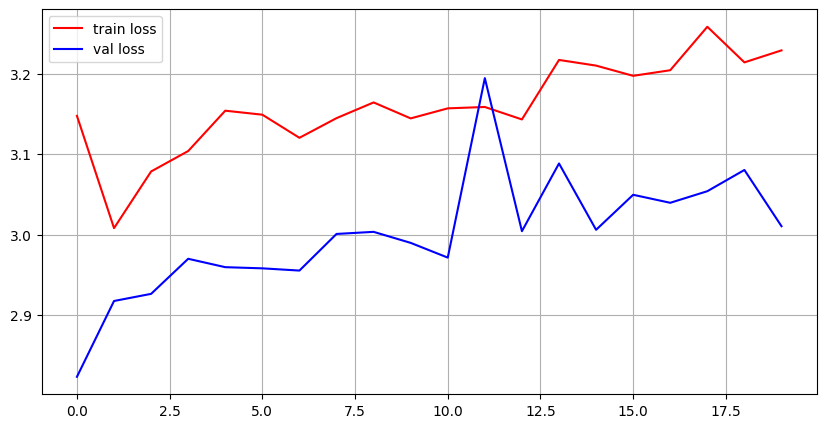

In [63]:
x = range(config.EPOCHS)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(x, train_losses, 'r', label='train loss')
plt.plot(x, valid_losses, 'b', label='val loss') 
plt.legend()
plt.grid()
plt.show()

In [64]:
diff = np.array(valid_losses) - np.array(train_losses)
mean_uplift = np.mean(100 * (diff[1:] - diff[:-1]) / diff[:-1])

print(f"Avg uplift of diff between train and val = {mean_uplift}")

Avg uplift of diff between train and val = -25.79871623486695


In [66]:
print("Example of best-translated sentenses:")
print("------------------------------------")
i = 0
for orig, gen in zip(orig_text, pred_text):
    if set(orig) == set(gen):
        i += 1
        print(f"\t{i}) Original: {' '.join(orig)}")
        print(f"\t{i}) Generated: {' '.join(gen)}")
    if i == 10:
        break

Example of best-translated sentenses:
------------------------------------


In [68]:
print("Example of worst-translated sentenses:")
print("------------------------------------")
i = 0
for orig, gen in zip(orig_text, pred_text):
    if len(set(orig).intersection(set(gen))) == 1:
        i += 1
        print(f"\t{i}) Original: {' '.join(orig)}")
        print(f"\t{i}) Generated: {' '.join(gen)}")
    if i == 10:
        break

Example of worst-translated sentenses:
------------------------------------
	1) Original: апартаменты t valkennestje находятся в тихом уголке города дехаан в  минутах ходьбы от песчаного пляжа на побережье северного моря
	1) Generated: от
	2) Original: в номерах отеля residencial melba есть ванная комната и спутниковое телевидение
	2) Generated: в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в от от от от в в от от от в от от в от в от кроме от кроме от поездка от от от от от от от от от в от в поездка от в от в поездка от в от в поездка от в от в поездка от в от в поездка от в от в от в поездка от в от в от в поездка от в от в поездка от в от в поездка от в от в поездка от в от в поездка от в поездка от в поездка от в поездка от в поездка от в поездка от в поездка от в поездка от